In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import cv2

In [3]:
img_files = list(Path("C:\\Users\\alistar\\Desktop\\ds\\video_segmentation\\data\\tmp\\acm_traffic_light").glob("*.jpg"))
chuck_size = 10

In [4]:
img_files = sorted(img_files, key=lambda file: int(file.name.split(".")[0])) #skip the first img

In [5]:
img_files_blocks = np.array_split(img_files, len(img_files)//chuck_size)

In [6]:
from collections import defaultdict
from slide_segmentation.util import *
from slide_segmentation.ocr.ocr_process import *

In [7]:
#video_name = img_file_dir.split("\\")[-1]
img_file_dict = {int(file.name.split(".")[0]): cv2.imread(str(file), cv2.IMREAD_GRAYSCALE) 
                 for file in img_files}

In [8]:
ocr = init_ocr()

C:\Users\alistar\Anaconda3\lib\site-packages\scipy\special\orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import (exp, inf, pi, sqrt, floor, sin, cos, around, int,
C:\Users\alistar\Anaconda3\lib\site-packages\scipy\sparse\sputils.py:16: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
C:\Users\alistar\Anaconda3\lib\site-packages\scipy\linalg\__init__.py:217: DeprecationWarning: The module numpy.dual is deprecated.  Instead of us

Namespace(cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\alistar/.paddleocr/cls', cls_thresh=0.9, det=True, det_algorithm='DB', det_db_box_thresh=0.5, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.6, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:/Users/alistar/Desktop/ds/PaddleOCR-release-2.1/ch_ppocr_server_v2.0_det_infer/', drop_score=0.5, enable_mkldnn=False, gpu_mem=8000, image_dir='', ir_optim=True, label_list=['0', '180'], lang='ch', max_text_length=25, rec=True, rec_algorithm='CRNN', rec_batch_num=6, rec_char_dict_path='C:/Users/alistar/Desktop/ds/PaddleOCR-release-2.1/ppocr/utils/en_dict.txt', rec_char_type='ch', rec_image_shape='3, 32, 320', rec_model_dir='C:/Users/alistar/Desktop/ds/PaddleOCR-release-2.1/models/en_number_mobile_v2.0_rec_infer/', use_angle_cls=False, use_dilation=False, use_gpu=True, use_pdserving=False, use_space_char=

In [9]:
img_data_dict = defaultdict(lambda : None)
img_data_dict.update(img_file_dict)
ocr_data_dict = defaultdict(lambda : None)

def get_ocr_result(frame_index):
    global ocr_data_dict
    if frame_index in ocr_data_dict:
        return ocr_data_dict[frame_index]
    # check cache
    # check ocr results 
    img_data = img_data_dict[frame_index]
    if img_data.shape[0] > 1:
        ocr_result = ocr.ocr(img_data)
        ocr_data_dict[frame_index] = ocr_result
        return ocr_result
    else:
        return None
    
    
#### make features
doc_diff_comparator = docDiffBuilder().\
        add_metric("jaccard_letter", jaccard_letter_dissim).\
        add_metric("jaccard", jaccard_str).\
        add_metric("letter_dis",letter_dissim).\
        add_metric("word_dis", word_dissim)

def make_feature(ocr1, ocr2):
    doc1 = get_paragraph(ocr1)
    doc2 = get_paragraph(ocr2)
    doc_compare_dict = doc_diff_comparator.compare(doc1, doc2)
    doc_compare_dict['frame_token_ct'] = len(doc1)
    # need to test if dataframe results results
    feature_df = pd.DataFrame([doc_compare_dict])
    feature_df = feature_df.rename(columns={'letter_dis':'letter_dissim'})
    #feature_df['dissimilarity'] =  feature_df['jaccard']
    return feature_df

from joblib import dump, load
MODEL_PATH = 'C:\\Users\\alistar\\Desktop\\ds\\video_segmentation\\models\\ocr_tree.joblib'
feature_names = ['jaccard', 'jaccard_letter', 'frame_token_ct',
       'word_dis', 'letter_dissim'] #'dissimilarity', 
new_slide_clf = load(MODEL_PATH)
def check_if_frame_break_point(frame_index, model):
    if frame_index == 0:
        return False
    curr_frame, prev_frame = img_data_dict[frame_index], img_data_dict[frame_index-1]
    ocr1, ocr2 = get_ocr_result(frame_index), get_ocr_result(frame_index-1),
    try:
        feature_record = make_feature(ocr1, ocr2)
        if_break_point = model.predict(feature_record)[0]
    except Exception as e:
        print(e)
        print(ocr1)
        print(ocr2)
        print(feature_record)
    return if_break_point

def check_if_frame_diff(frame_1_index, frame_2_index, model):
    ocr1, ocr2 = get_ocr_result(frame_1_index), get_ocr_result(frame_2_index)
    try:
        if_break_point = model.predict(make_feature(ocr1, ocr2))[0]
    except Exception as e:
        print(e)
        print(make_feature(ocr1, ocr2))
    return if_break_point

def find_all_new_slides(start_frame_index: int, end_frame_index: int, model):
    new_slide_indices = []
    for i in range(start_frame_index+1, end_frame_index+1):
        is_new_slide = check_if_frame_break_point(i, model)
        if is_new_slide:
            new_slide_indices.append(i)
    return new_slide_indices

C:\Users\alistar\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\alistar\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=T

In [10]:
doc_compare_dict={'jaccard_letter': 0.3, 'jaccard': 0.8780487804878049, 'letter_dis': 0.567398119122257, 'word_dis': 0.6923076923076923, 'frame_token_ct': 319}
feature_df = pd.DataFrame([doc_compare_dict])
feature_df = feature_df.rename(columns={'letter_dis':'letter_dissim'})
feature_df

,jaccard_letter,jaccard,letter_dissim,word_dis,frame_token_ct
0,0.3,0.878049,0.567398,0.692308,319


In [11]:
new_slide_clf.predict(feature_df)[0]

True

In [12]:
len(img_files_blocks)

319

In [13]:
new_slide_df = pd.DataFrame()
break_points = []

i = 0
#max_count = 20
for img_files_block in img_files_blocks:
    print("#####")
    print("looking at new block")
    print("#####")
    # check if the first one is split point
    first_file = img_files_block[0]
    frame_index = int(first_file.name.split(".")[0])
    is_break_point = check_if_frame_break_point(frame_index, new_slide_clf)
    if is_break_point:
        break_points.append(frame_index)
    last_file = img_files_block[-1]
    last_file_frame_index = int(last_file.name.split(".")[0])
    same_slide_block = not check_if_frame_diff(frame_index, last_file_frame_index, new_slide_clf)
    print(frame_index)
    print(is_break_point)
    print(f"{frame_index} is {is_break_point} breakpoint")
    print(f"block index range: {frame_index, last_file_frame_index}")
    print(f"same slide block: {same_slide_block}")
    print("\n\n")
    
    block_new_slides = []
    if not same_slide_block:
        block_new_slides = find_all_new_slides(frame_index, last_file_frame_index, new_slide_clf)
    print(f"block_new_slides: {block_new_slides}")
    break_points += block_new_slides
    i+=1
    #if i == max_count:
    #    break
    

#####
looking at new block
#####
[2022/06/03 16:55:17] root INFO: dt_boxes num : 18, elapse : 0.47002601623535156
[2022/06/03 16:55:17] root INFO: rec_res num  : 18, elapse : 0.43372297286987305
[2022/06/03 16:55:18] root INFO: dt_boxes num : 16, elapse : 0.3980143070220947
[2022/06/03 16:55:18] root INFO: rec_res num  : 16, elapse : 0.3774452209472656
0
False
0 is False breakpoint
block index range: (0, 10)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 16:55:18] root INFO: dt_boxes num : 15, elapse : 0.40006041526794434
[2022/06/03 16:55:19] root INFO: rec_res num  : 15, elapse : 0.3198854923248291
[2022/06/03 16:55:19] root INFO: dt_boxes num : 17, elapse : 0.37654614448547363
[2022/06/03 16:55:20] root INFO: rec_res num  : 17, elapse : 0.41789746284484863
11
False
11 is False breakpoint
block index range: (11, 21)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 16:55:20] root INFO: dt_boxes num

[2022/06/03 16:56:09] root INFO: dt_boxes num : 18, elapse : 0.4276125431060791
[2022/06/03 16:56:09] root INFO: rec_res num  : 18, elapse : 0.4073457717895508
[2022/06/03 16:56:09] root INFO: dt_boxes num : 13, elapse : 0.38208794593811035
[2022/06/03 16:56:10] root INFO: rec_res num  : 13, elapse : 0.24434518814086914
124
False
124 is False breakpoint
block index range: (124, 133)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 16:56:10] root INFO: dt_boxes num : 17, elapse : 0.39856886863708496
[2022/06/03 16:56:10] root INFO: rec_res num  : 17, elapse : 0.3440837860107422
[2022/06/03 16:56:11] root INFO: dt_boxes num : 18, elapse : 0.3999314308166504
[2022/06/03 16:56:11] root INFO: rec_res num  : 18, elapse : 0.4201972484588623
134
False
134 is False breakpoint
block index range: (134, 143)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 16:56:12] root INFO: dt_boxes num : 15, elapse : 0.414699

[2022/06/03 16:56:41] root INFO: rec_res num  : 6, elapse : 0.637296199798584
[2022/06/03 16:56:41] root INFO: dt_boxes num : 7, elapse : 0.34607529640197754
[2022/06/03 16:56:42] root INFO: rec_res num  : 7, elapse : 0.5609204769134521
[2022/06/03 16:56:42] root INFO: dt_boxes num : 7, elapse : 0.34811830520629883
[2022/06/03 16:56:43] root INFO: rec_res num  : 7, elapse : 0.5379221439361572
[2022/06/03 16:56:43] root INFO: dt_boxes num : 8, elapse : 0.3839733600616455
[2022/06/03 16:56:44] root INFO: rec_res num  : 8, elapse : 0.5714719295501709
block_new_slides: [203]
#####
looking at new block
#####
[2022/06/03 16:56:44] root INFO: dt_boxes num : 27, elapse : 0.3957188129425049
[2022/06/03 16:56:45] root INFO: rec_res num  : 27, elapse : 1.079075574874878
[2022/06/03 16:56:46] root INFO: dt_boxes num : 26, elapse : 0.4198925495147705
[2022/06/03 16:56:47] root INFO: rec_res num  : 26, elapse : 1.2184715270996094
204
False
204 is False breakpoint
block index range: (204, 213)
same s

334
False
334 is False breakpoint
block index range: (334, 343)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 16:57:35] root INFO: dt_boxes num : 16, elapse : 0.3851299285888672
[2022/06/03 16:57:37] root INFO: rec_res num  : 16, elapse : 1.137465238571167
[2022/06/03 16:57:37] root INFO: dt_boxes num : 17, elapse : 0.44765496253967285
[2022/06/03 16:57:38] root INFO: rec_res num  : 17, elapse : 1.3471148014068604
344
False
344 is False breakpoint
block index range: (344, 353)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 16:57:39] root INFO: dt_boxes num : 17, elapse : 0.4235069751739502
[2022/06/03 16:57:40] root INFO: rec_res num  : 17, elapse : 1.280992031097412
[2022/06/03 16:57:41] root INFO: dt_boxes num : 16, elapse : 0.4207947254180908
[2022/06/03 16:57:42] root INFO: rec_res num  : 16, elapse : 1.123880386352539
354
False
354 is False breakpoint
block index range: (354, 363)
same slide

484
False
484 is False breakpoint
block index range: (484, 493)
same slide block: False



[2022/06/03 16:58:35] root INFO: dt_boxes num : 13, elapse : 0.4198751449584961
[2022/06/03 16:58:36] root INFO: rec_res num  : 13, elapse : 0.8575384616851807
[2022/06/03 16:58:36] root INFO: dt_boxes num : 13, elapse : 0.37160730361938477
[2022/06/03 16:58:37] root INFO: rec_res num  : 13, elapse : 0.9088482856750488
[2022/06/03 16:58:37] root INFO: dt_boxes num : 13, elapse : 0.3589925765991211
[2022/06/03 16:58:38] root INFO: rec_res num  : 13, elapse : 0.8676843643188477
[2022/06/03 16:58:39] root INFO: dt_boxes num : 13, elapse : 0.3914613723754883
[2022/06/03 16:58:40] root INFO: rec_res num  : 13, elapse : 0.8796720504760742
[2022/06/03 16:58:40] root INFO: dt_boxes num : 13, elapse : 0.397446870803833
[2022/06/03 16:58:41] root INFO: rec_res num  : 13, elapse : 0.9249258041381836
[2022/06/03 16:58:42] root INFO: dt_boxes num : 15, elapse : 0.4540104866027832
[2022/06/03 16:58:43] root IN

[2022/06/03 16:59:32] root INFO: dt_boxes num : 7, elapse : 0.503375768661499
[2022/06/03 16:59:32] root INFO: rec_res num  : 7, elapse : 0.49726414680480957
[2022/06/03 16:59:33] root INFO: dt_boxes num : 7, elapse : 0.45897984504699707
[2022/06/03 16:59:33] root INFO: rec_res num  : 7, elapse : 0.5167679786682129
[2022/06/03 16:59:34] root INFO: dt_boxes num : 8, elapse : 0.44986414909362793
[2022/06/03 16:59:34] root INFO: rec_res num  : 8, elapse : 0.7173962593078613
[2022/06/03 16:59:35] root INFO: dt_boxes num : 8, elapse : 0.3992931842803955
[2022/06/03 16:59:36] root INFO: rec_res num  : 8, elapse : 0.7045023441314697
[2022/06/03 16:59:36] root INFO: dt_boxes num : 9, elapse : 0.4066612720489502
[2022/06/03 16:59:37] root INFO: rec_res num  : 9, elapse : 0.626939058303833
[2022/06/03 16:59:37] root INFO: dt_boxes num : 9, elapse : 0.38197827339172363
[2022/06/03 16:59:38] root INFO: rec_res num  : 9, elapse : 0.6017353534698486
[2022/06/03 16:59:38] root INFO: dt_boxes num : 10

[2022/06/03 17:00:38] root INFO: rec_res num  : 61, elapse : 1.1798408031463623
[2022/06/03 17:00:39] root INFO: dt_boxes num : 59, elapse : 0.42087435722351074
[2022/06/03 17:00:40] root INFO: rec_res num  : 59, elapse : 1.083890676498413
[2022/06/03 17:00:40] root INFO: dt_boxes num : 65, elapse : 0.4784090518951416
[2022/06/03 17:00:42] root INFO: rec_res num  : 65, elapse : 1.2706191539764404
[2022/06/03 17:00:42] root INFO: dt_boxes num : 61, elapse : 0.36502861976623535
[2022/06/03 17:00:43] root INFO: rec_res num  : 61, elapse : 1.2431840896606445
[2022/06/03 17:00:44] root INFO: dt_boxes num : 57, elapse : 0.6616990566253662
[2022/06/03 17:00:45] root INFO: rec_res num  : 57, elapse : 1.0797913074493408
block_new_slides: [723]
#####
looking at new block
#####
[2022/06/03 17:00:45] root INFO: dt_boxes num : 16, elapse : 0.3665435314178467
[2022/06/03 17:00:47] root INFO: rec_res num  : 16, elapse : 1.157047986984253
[2022/06/03 17:00:47] root INFO: dt_boxes num : 13, elapse : 0.

[2022/06/03 17:01:33] root INFO: dt_boxes num : 19, elapse : 0.3679635524749756
[2022/06/03 17:01:35] root INFO: rec_res num  : 19, elapse : 1.2259137630462646
[2022/06/03 17:01:35] root INFO: dt_boxes num : 19, elapse : 0.36003804206848145
[2022/06/03 17:01:36] root INFO: rec_res num  : 19, elapse : 1.0834994316101074
[2022/06/03 17:01:37] root INFO: dt_boxes num : 20, elapse : 0.3611016273498535
[2022/06/03 17:01:37] root INFO: rec_res num  : 20, elapse : 0.8101580142974854
[2022/06/03 17:01:38] root INFO: dt_boxes num : 20, elapse : 0.32213830947875977
[2022/06/03 17:01:39] root INFO: rec_res num  : 20, elapse : 0.8370156288146973
block_new_slides: [838]
#####
looking at new block
#####
[2022/06/03 17:01:39] root INFO: dt_boxes num : 20, elapse : 0.3311190605163574
[2022/06/03 17:01:40] root INFO: rec_res num  : 20, elapse : 0.8323428630828857
[2022/06/03 17:01:40] root INFO: dt_boxes num : 20, elapse : 0.30817389488220215
[2022/06/03 17:01:41] root INFO: rec_res num  : 20, elapse :

944
True
944 is True breakpoint
block index range: (944, 953)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:02:36] root INFO: dt_boxes num : 20, elapse : 0.34819507598876953
[2022/06/03 17:02:37] root INFO: rec_res num  : 20, elapse : 0.7744371891021729
[2022/06/03 17:02:37] root INFO: dt_boxes num : 20, elapse : 0.320786714553833
[2022/06/03 17:02:38] root INFO: rec_res num  : 20, elapse : 0.7559902667999268
954
False
954 is False breakpoint
block index range: (954, 963)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:02:38] root INFO: dt_boxes num : 19, elapse : 0.31678318977355957
[2022/06/03 17:02:39] root INFO: rec_res num  : 19, elapse : 0.9030623435974121
[2022/06/03 17:02:40] root INFO: dt_boxes num : 21, elapse : 0.33002305030822754
[2022/06/03 17:02:40] root INFO: rec_res num  : 21, elapse : 0.7719283103942871
964
False
964 is False breakpoint
block index range: (964, 973)
same sli

[2022/06/03 17:03:11] root INFO: dt_boxes num : 25, elapse : 0.317183256149292
[2022/06/03 17:03:12] root INFO: rec_res num  : 25, elapse : 0.609722375869751
[2022/06/03 17:03:12] root INFO: dt_boxes num : 25, elapse : 0.3463585376739502
[2022/06/03 17:03:13] root INFO: rec_res num  : 25, elapse : 0.6370885372161865
[2022/06/03 17:03:13] root INFO: dt_boxes num : 25, elapse : 0.31273508071899414
[2022/06/03 17:03:14] root INFO: rec_res num  : 25, elapse : 0.5845439434051514
block_new_slides: [1075]
#####
looking at new block
#####
[2022/06/03 17:03:14] root INFO: dt_boxes num : 26, elapse : 0.3227558135986328
[2022/06/03 17:03:15] root INFO: rec_res num  : 26, elapse : 0.6179459095001221
[2022/06/03 17:03:15] root INFO: dt_boxes num : 24, elapse : 0.33245038986206055
[2022/06/03 17:03:16] root INFO: rec_res num  : 24, elapse : 0.5567903518676758
1084
False
1084 is False breakpoint
block index range: (1084, 1093)
same slide block: True



block_new_slides: []
#####
looking at new block


[2022/06/03 17:03:48] root INFO: rec_res num  : 17, elapse : 0.5392146110534668
[2022/06/03 17:03:49] root INFO: dt_boxes num : 17, elapse : 0.3089265823364258
[2022/06/03 17:03:49] root INFO: rec_res num  : 17, elapse : 0.5429890155792236
[2022/06/03 17:03:50] root INFO: dt_boxes num : 16, elapse : 0.3098726272583008
[2022/06/03 17:03:50] root INFO: rec_res num  : 16, elapse : 0.47935962677001953
[2022/06/03 17:03:50] root INFO: dt_boxes num : 16, elapse : 0.3037869930267334
[2022/06/03 17:03:51] root INFO: rec_res num  : 16, elapse : 0.4960503578186035
[2022/06/03 17:03:51] root INFO: dt_boxes num : 16, elapse : 0.30113649368286133
[2022/06/03 17:03:52] root INFO: rec_res num  : 16, elapse : 0.47336673736572266
[2022/06/03 17:03:52] root INFO: dt_boxes num : 15, elapse : 0.3018374443054199
[2022/06/03 17:03:53] root INFO: rec_res num  : 15, elapse : 0.4479832649230957
block_new_slides: [1205]
#####
looking at new block
#####
[2022/06/03 17:03:53] root INFO: dt_boxes num : 15, elapse 

[2022/06/03 17:04:32] root INFO: rec_res num  : 4, elapse : 0.11630511283874512
[2022/06/03 17:04:32] root INFO: dt_boxes num : 4, elapse : 0.3168985843658447
[2022/06/03 17:04:32] root INFO: rec_res num  : 4, elapse : 0.1061241626739502
[2022/06/03 17:04:33] root INFO: dt_boxes num : 4, elapse : 0.3639242649078369
[2022/06/03 17:04:33] root INFO: rec_res num  : 4, elapse : 0.11035490036010742
block_new_slides: [1318, 1319]
#####
looking at new block
#####
[2022/06/03 17:04:33] root INFO: dt_boxes num : 5, elapse : 0.33397936820983887
[2022/06/03 17:04:33] root INFO: rec_res num  : 5, elapse : 0.13016557693481445
[2022/06/03 17:04:34] root INFO: dt_boxes num : 13, elapse : 0.33107829093933105
[2022/06/03 17:04:34] root INFO: rec_res num  : 13, elapse : 0.6107831001281738
1324
False
1324 is False breakpoint
block index range: (1324, 1333)
same slide block: False



[2022/06/03 17:04:35] root INFO: dt_boxes num : 6, elapse : 0.31853199005126953
[2022/06/03 17:04:35] root INFO: rec_res nu

[2022/06/03 17:05:17] root INFO: rec_res num  : 12, elapse : 1.1524877548217773
[2022/06/03 17:05:18] root INFO: dt_boxes num : 13, elapse : 0.31136083602905273
[2022/06/03 17:05:19] root INFO: rec_res num  : 13, elapse : 1.1771955490112305
[2022/06/03 17:05:19] root INFO: dt_boxes num : 13, elapse : 0.3070509433746338
[2022/06/03 17:05:20] root INFO: rec_res num  : 13, elapse : 1.1845588684082031
[2022/06/03 17:05:21] root INFO: dt_boxes num : 13, elapse : 0.3163158893585205
[2022/06/03 17:05:22] root INFO: rec_res num  : 13, elapse : 1.246882677078247
[2022/06/03 17:05:22] root INFO: dt_boxes num : 13, elapse : 0.3088545799255371
[2022/06/03 17:05:24] root INFO: rec_res num  : 13, elapse : 1.2709994316101074
[2022/06/03 17:05:24] root INFO: dt_boxes num : 13, elapse : 0.31740880012512207
[2022/06/03 17:05:25] root INFO: rec_res num  : 13, elapse : 1.213930606842041
[2022/06/03 17:05:26] root INFO: dt_boxes num : 13, elapse : 0.31180357933044434
[2022/06/03 17:05:27] root INFO: rec_re

[2022/06/03 17:06:07] root INFO: rec_res num  : 4, elapse : 0.16856002807617188
[2022/06/03 17:06:07] root INFO: dt_boxes num : 4, elapse : 0.34015703201293945
[2022/06/03 17:06:08] root INFO: rec_res num  : 4, elapse : 0.1569051742553711
[2022/06/03 17:06:08] root INFO: dt_boxes num : 4, elapse : 0.33972907066345215
[2022/06/03 17:06:08] root INFO: rec_res num  : 4, elapse : 0.15738487243652344
[2022/06/03 17:06:08] root INFO: dt_boxes num : 4, elapse : 0.3166165351867676
[2022/06/03 17:06:09] root INFO: rec_res num  : 4, elapse : 0.14890027046203613
[2022/06/03 17:06:09] root INFO: dt_boxes num : 4, elapse : 0.3252592086791992
[2022/06/03 17:06:09] root INFO: rec_res num  : 4, elapse : 0.15104222297668457
[2022/06/03 17:06:09] root INFO: dt_boxes num : 16, elapse : 0.3339214324951172
[2022/06/03 17:06:11] root INFO: rec_res num  : 16, elapse : 1.4238686561584473
[2022/06/03 17:06:11] root INFO: dt_boxes num : 32, elapse : 0.3196730613708496
[2022/06/03 17:06:14] root INFO: rec_res nu

1614
False
1614 is False breakpoint
block index range: (1614, 1623)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:06:46] root INFO: dt_boxes num : 13, elapse : 0.30645036697387695
[2022/06/03 17:06:46] root INFO: rec_res num  : 13, elapse : 0.30477380752563477
[2022/06/03 17:06:46] root INFO: dt_boxes num : 14, elapse : 0.31093859672546387
[2022/06/03 17:06:47] root INFO: rec_res num  : 14, elapse : 0.325960636138916
1624
False
1624 is False breakpoint
block index range: (1624, 1633)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:06:47] root INFO: dt_boxes num : 13, elapse : 0.3111405372619629
[2022/06/03 17:06:47] root INFO: rec_res num  : 13, elapse : 0.3106880187988281
[2022/06/03 17:06:48] root INFO: dt_boxes num : 4, elapse : 0.3059961795806885
[2022/06/03 17:06:48] root INFO: rec_res num  : 4, elapse : 0.13514351844787598
1634
False
1634 is False breakpoint
block index range: (1634, 1

[2022/06/03 17:07:22] root INFO: dt_boxes num : 19, elapse : 0.314197301864624
[2022/06/03 17:07:22] root INFO: rec_res num  : 19, elapse : 0.6950631141662598
[2022/06/03 17:07:23] root INFO: dt_boxes num : 21, elapse : 0.3227498531341553
[2022/06/03 17:07:23] root INFO: rec_res num  : 21, elapse : 0.778505802154541
[2022/06/03 17:07:24] root INFO: dt_boxes num : 21, elapse : 0.31359267234802246
[2022/06/03 17:07:24] root INFO: rec_res num  : 21, elapse : 0.7803378105163574
[2022/06/03 17:07:25] root INFO: dt_boxes num : 21, elapse : 0.3262903690338135
[2022/06/03 17:07:26] root INFO: rec_res num  : 21, elapse : 0.7920753955841064
[2022/06/03 17:07:26] root INFO: dt_boxes num : 21, elapse : 0.318798303604126
[2022/06/03 17:07:27] root INFO: rec_res num  : 21, elapse : 0.7562053203582764
[2022/06/03 17:07:27] root INFO: dt_boxes num : 21, elapse : 0.32316040992736816
[2022/06/03 17:07:28] root INFO: rec_res num  : 21, elapse : 0.7637753486633301
block_new_slides: [1763]
#####
looking at

1884
False
1884 is False breakpoint
block index range: (1884, 1893)
same slide block: False



[2022/06/03 17:08:02] root INFO: dt_boxes num : 7, elapse : 0.37023329734802246
[2022/06/03 17:08:02] root INFO: rec_res num  : 7, elapse : 0.5889129638671875
[2022/06/03 17:08:03] root INFO: dt_boxes num : 7, elapse : 0.33949971199035645
[2022/06/03 17:08:03] root INFO: rec_res num  : 7, elapse : 0.5818672180175781
[2022/06/03 17:08:04] root INFO: dt_boxes num : 7, elapse : 0.3477344512939453
[2022/06/03 17:08:04] root INFO: rec_res num  : 7, elapse : 0.5996978282928467
[2022/06/03 17:08:05] root INFO: dt_boxes num : 7, elapse : 0.36333370208740234
[2022/06/03 17:08:05] root INFO: rec_res num  : 7, elapse : 0.5628879070281982
[2022/06/03 17:08:05] root INFO: dt_boxes num : 7, elapse : 0.31300973892211914
[2022/06/03 17:08:06] root INFO: rec_res num  : 7, elapse : 0.5665380954742432
[2022/06/03 17:08:06] root INFO: dt_boxes num : 7, elapse : 0.31029224395751953
[2022/06/03 17:08:07] root INFO

[2022/06/03 17:08:45] root INFO: dt_boxes num : 23, elapse : 0.3558332920074463
[2022/06/03 17:08:46] root INFO: rec_res num  : 23, elapse : 0.9801681041717529
[2022/06/03 17:08:46] root INFO: dt_boxes num : 22, elapse : 0.3317255973815918
[2022/06/03 17:08:47] root INFO: rec_res num  : 22, elapse : 0.9301021099090576
1984
False
1984 is False breakpoint
block index range: (1984, 1993)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:08:48] root INFO: dt_boxes num : 22, elapse : 0.31854724884033203
[2022/06/03 17:08:49] root INFO: rec_res num  : 22, elapse : 0.9285726547241211
[2022/06/03 17:08:49] root INFO: dt_boxes num : 23, elapse : 0.32130861282348633
[2022/06/03 17:08:50] root INFO: rec_res num  : 23, elapse : 0.969649076461792
1994
False
1994 is False breakpoint
block index range: (1994, 2003)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:08:50] root INFO: dt_boxes num : 23, elapse : 0.

[2022/06/03 17:09:32] root INFO: rec_res num  : 22, elapse : 0.9993495941162109
2154
False
2154 is False breakpoint
block index range: (2154, 2163)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:09:32] root INFO: dt_boxes num : 22, elapse : 0.3012259006500244
[2022/06/03 17:09:33] root INFO: rec_res num  : 22, elapse : 1.005326747894287
[2022/06/03 17:09:33] root INFO: dt_boxes num : 21, elapse : 0.3251304626464844
[2022/06/03 17:09:34] root INFO: rec_res num  : 21, elapse : 1.0282416343688965
2164
False
2164 is False breakpoint
block index range: (2164, 2173)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:09:35] root INFO: dt_boxes num : 20, elapse : 0.3123602867126465
[2022/06/03 17:09:36] root INFO: rec_res num  : 20, elapse : 0.9475650787353516
[2022/06/03 17:09:36] root INFO: dt_boxes num : 21, elapse : 0.30820679664611816
[2022/06/03 17:09:37] root INFO: rec_res num  : 21, elapse : 0.9

[2022/06/03 17:10:21] root INFO: dt_boxes num : 16, elapse : 0.3042733669281006
[2022/06/03 17:10:21] root INFO: rec_res num  : 16, elapse : 0.7635633945465088
2304
False
2304 is False breakpoint
block index range: (2304, 2313)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:10:22] root INFO: dt_boxes num : 16, elapse : 0.301220178604126
[2022/06/03 17:10:23] root INFO: rec_res num  : 16, elapse : 0.7914731502532959
[2022/06/03 17:10:23] root INFO: dt_boxes num : 15, elapse : 0.2976369857788086
[2022/06/03 17:10:24] root INFO: rec_res num  : 15, elapse : 0.7079041004180908
2314
False
2314 is False breakpoint
block index range: (2314, 2323)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:10:24] root INFO: dt_boxes num : 15, elapse : 0.30518531799316406
[2022/06/03 17:10:25] root INFO: rec_res num  : 15, elapse : 0.7196803092956543
[2022/06/03 17:10:25] root INFO: dt_boxes num : 16, elapse : 0.3

[2022/06/03 17:11:02] root INFO: dt_boxes num : 16, elapse : 0.3201174736022949
[2022/06/03 17:11:03] root INFO: rec_res num  : 16, elapse : 0.9259936809539795
[2022/06/03 17:11:03] root INFO: dt_boxes num : 13, elapse : 0.3071775436401367
[2022/06/03 17:11:04] root INFO: rec_res num  : 13, elapse : 0.8716695308685303
2484
False
2484 is False breakpoint
block index range: (2484, 2493)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:11:04] root INFO: dt_boxes num : 13, elapse : 0.3171525001525879
[2022/06/03 17:11:05] root INFO: rec_res num  : 13, elapse : 0.896132230758667
[2022/06/03 17:11:06] root INFO: dt_boxes num : 14, elapse : 0.3171520233154297
[2022/06/03 17:11:06] root INFO: rec_res num  : 14, elapse : 0.8866677284240723
2494
False
2494 is False breakpoint
block index range: (2494, 2503)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:11:07] root INFO: dt_boxes num : 15, elapse : 0.34

[2022/06/03 17:11:52] root INFO: dt_boxes num : 23, elapse : 0.3211402893066406
[2022/06/03 17:11:53] root INFO: rec_res num  : 23, elapse : 1.0414979457855225
[2022/06/03 17:11:53] root INFO: dt_boxes num : 24, elapse : 0.3041872978210449
[2022/06/03 17:11:54] root INFO: rec_res num  : 24, elapse : 1.236713171005249
[2022/06/03 17:11:55] root INFO: dt_boxes num : 25, elapse : 0.3321115970611572
[2022/06/03 17:11:56] root INFO: rec_res num  : 25, elapse : 0.9973561763763428
[2022/06/03 17:11:56] root INFO: dt_boxes num : 4, elapse : 0.3041856288909912
[2022/06/03 17:11:56] root INFO: rec_res num  : 4, elapse : 0.11170101165771484
[2022/06/03 17:11:56] root INFO: dt_boxes num : 4, elapse : 0.29919981956481934
[2022/06/03 17:11:57] root INFO: rec_res num  : 4, elapse : 0.11369562149047852
[2022/06/03 17:11:57] root INFO: dt_boxes num : 4, elapse : 0.2952139377593994
[2022/06/03 17:11:57] root INFO: rec_res num  : 4, elapse : 0.11668825149536133
[2022/06/03 17:11:57] root INFO: dt_boxes n

[2022/06/03 17:12:13] root INFO: dt_boxes num : 21, elapse : 0.30965256690979004
[2022/06/03 17:12:13] root INFO: rec_res num  : 21, elapse : 0.4787437915802002
[2022/06/03 17:12:14] root INFO: dt_boxes num : 19, elapse : 0.29817724227905273
[2022/06/03 17:12:14] root INFO: rec_res num  : 19, elapse : 0.4407694339752197
2754
False
2754 is False breakpoint
block index range: (2754, 2763)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:12:14] root INFO: dt_boxes num : 18, elapse : 0.30219173431396484
[2022/06/03 17:12:15] root INFO: rec_res num  : 18, elapse : 0.4259154796600342
[2022/06/03 17:12:15] root INFO: dt_boxes num : 18, elapse : 0.33164119720458984
[2022/06/03 17:12:16] root INFO: rec_res num  : 18, elapse : 0.4551351070404053
2764
False
2764 is False breakpoint
block index range: (2764, 2773)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:12:16] root INFO: dt_boxes num : 19, elapse :

[2022/06/03 17:12:45] root INFO: dt_boxes num : 13, elapse : 0.31511402130126953
[2022/06/03 17:12:46] root INFO: rec_res num  : 13, elapse : 0.6021645069122314
[2022/06/03 17:12:46] root INFO: dt_boxes num : 14, elapse : 0.304187536239624
[2022/06/03 17:12:47] root INFO: rec_res num  : 14, elapse : 0.8751790523529053
2904
False
2904 is False breakpoint
block index range: (2904, 2913)
same slide block: False



[2022/06/03 17:12:47] root INFO: dt_boxes num : 12, elapse : 0.32211899757385254
[2022/06/03 17:12:48] root INFO: rec_res num  : 12, elapse : 0.6632537841796875
[2022/06/03 17:12:48] root INFO: dt_boxes num : 13, elapse : 0.3011667728424072
[2022/06/03 17:12:49] root INFO: rec_res num  : 13, elapse : 0.589423418045044
[2022/06/03 17:12:49] root INFO: dt_boxes num : 15, elapse : 0.3171525001525879
[2022/06/03 17:12:50] root INFO: rec_res num  : 15, elapse : 0.8546736240386963
[2022/06/03 17:12:51] root INFO: dt_boxes num : 15, elapse : 0.30219244956970215
[2022/06/03 17:12:51] ro

[2022/06/03 17:13:29] root INFO: rec_res num  : 16, elapse : 1.0172791481018066
[2022/06/03 17:13:29] root INFO: dt_boxes num : 17, elapse : 0.31116747856140137
[2022/06/03 17:13:30] root INFO: rec_res num  : 17, elapse : 1.074336051940918
[2022/06/03 17:13:30] root INFO: dt_boxes num : 15, elapse : 0.3012545108795166
[2022/06/03 17:13:31] root INFO: rec_res num  : 15, elapse : 0.9554424285888672
[2022/06/03 17:13:32] root INFO: dt_boxes num : 15, elapse : 0.34021902084350586
[2022/06/03 17:13:33] root INFO: rec_res num  : 15, elapse : 0.9601564407348633
[2022/06/03 17:13:33] root INFO: dt_boxes num : 16, elapse : 0.3161797523498535
[2022/06/03 17:13:34] root INFO: rec_res num  : 16, elapse : 1.0093252658843994
[2022/06/03 17:13:34] root INFO: dt_boxes num : 16, elapse : 0.30219149589538574
[2022/06/03 17:13:35] root INFO: rec_res num  : 16, elapse : 1.0085771083831787
[2022/06/03 17:13:36] root INFO: dt_boxes num : 16, elapse : 0.2982020378112793
[2022/06/03 17:13:37] root INFO: rec_r

[2022/06/03 17:14:03] root INFO: rec_res num  : 2, elapse : 0.024932861328125
[2022/06/03 17:14:03] root INFO: dt_boxes num : 3, elapse : 0.29122090339660645
[2022/06/03 17:14:03] root INFO: rec_res num  : 3, elapse : 0.036901235580444336
3144
False
3144 is False breakpoint
block index range: (3144, 3153)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:14:04] root INFO: dt_boxes num : 2, elapse : 0.29920005798339844
[2022/06/03 17:14:04] root INFO: rec_res num  : 2, elapse : 0.025954484939575195
[2022/06/03 17:14:04] root INFO: dt_boxes num : 2, elapse : 0.3011946678161621
[2022/06/03 17:14:04] root INFO: rec_res num  : 2, elapse : 0.030939579010009766
3154
False
3154 is False breakpoint
block index range: (3154, 3163)
same slide block: True



block_new_slides: []
#####
looking at new block
#####
[2022/06/03 17:14:04] root INFO: dt_boxes num : 2, elapse : 0.2932167053222656
[2022/06/03 17:14:04] root INFO: rec_res num  : 2, elapse : 0.035

In [14]:
break_points

[25,
 81,
 144,
 155,
 163,
 188,
 203,
 324,
 333,
 442,
 493,
 559,
 605,
 624,
 699,
 723,
 792,
 838,
 862,
 928,
 944,
 1015,
 1075,
 1133,
 1205,
 1263,
 1318,
 1319,
 1325,
 1326,
 1373,
 1425,
 1459,
 1491,
 1521,
 1522,
 1531,
 1574,
 1585,
 1588,
 1604,
 1657,
 1763,
 1856,
 1864,
 1892,
 1949,
 1957,
 2290,
 2519,
 2628,
 2732,
 2811,
 2907,
 2955,
 2963,
 3023,
 3090,
 3091]

In [ ]:
# miss 1635

# 2634 0> 2643  2653 63

# 2732

In [42]:
break_points

[48,
 85,
 136,
 137,
 312,
 343,
 344,
 346,
 347,
 348,
 349,
 350,
 353,
 354,
 376,
 383,
 384,
 428,
 432,
 458,
 459,
 460,
 462,
 463,
 464,
 465,
 475,
 476,
 477,
 480,
 484,
 486,
 487,
 488,
 549,
 551,
 552,
 554,
 555,
 556,
 557,
 558,
 559,
 563,
 565,
 566,
 569,
 571,
 574,
 580,
 595,
 596,
 599,
 600,
 601,
 604,
 607,
 610,
 611,
 613,
 614,
 615,
 616,
 617,
 626,
 628,
 634,
 658,
 713,
 714,
 715,
 718,
 719,
 720,
 757,
 758,
 759,
 760,
 761,
 765,
 777,
 823,
 835,
 836,
 837,
 846,
 848,
 857,
 884,
 897,
 905,
 935,
 1008,
 1038,
 1042,
 1045,
 1088,
 1089,
 1093,
 1095,
 1101,
 1164,
 1165,
 1171,
 1172,
 1173,
 1175,
 1206,
 1207,
 1217,
 1234,
 1238,
 1329,
 1331,
 1332,
 1334,
 1335,
 1336,
 1339,
 1340,
 1342,
 1343,
 1344,
 1367,
 1376,
 1382,
 1383,
 1442,
 1443,
 1451,
 1452,
 1453,
 1473,
 1478,
 1479,
 1486,
 1487,
 1493,
 1496,
 1502,
 1530,
 1531,
 1534,
 1535,
 1549,
 1550,
 1551,
 1554,
 1566,
 1595,
 1596,
 1597,
 1599,
 1650,
 1651,
 1654,
 1

In [15]:
len(break_points)

373

In [27]:
null_results = list(map(lambda record:record[0], filter(lambda record: record[1] == [], ocr_data_dict.items())))
null_results[:5]

[0, 32, 33, 55, 64]

In [25]:
set(break_points).intersection(set(null_results))

set()

#### img clustering

In [34]:
def img_dist(i1, i2):
    return np.sum((i1-i2)**2)

In [38]:
len(img_data_dict)

4145

In [35]:
img_dist(img_data_dict[55], img_data_dict[54])

86206505

In [37]:
img_dist(img_data_dict[54], img_data_dict[53])

847856

In [44]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

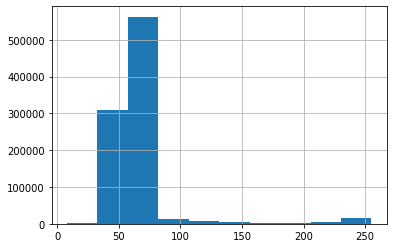

In [69]:
import matplotlib.pyplot as plt
pd.Series(img_data_dict[54].flatten()).hist()
plt.show()

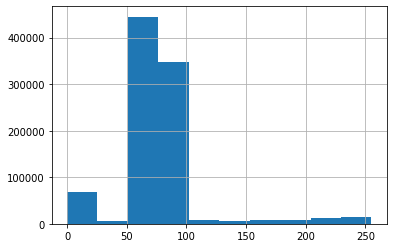

In [74]:
# 381 green
pd.Series(img_data_dict[888].flatten()).hist()
plt.show()

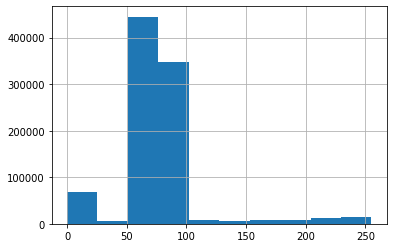

In [72]:
pd.Series(img_data_dict[888].flatten()).hist()
plt.show()

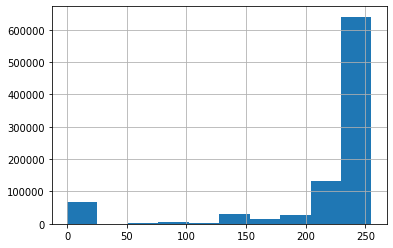

In [71]:
pd.Series(img_data_dict[814].flatten()).hist()
plt.show()

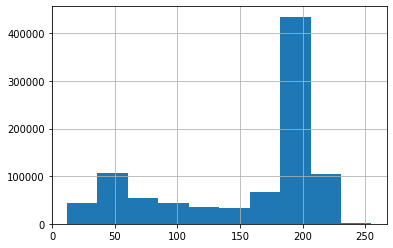

In [70]:
pd.Series(img_data_dict[55].flatten()).hist()
plt.show()

In [58]:
def compute_pairwise(lst, metric):
        n = len(lst)
        dist_lst = []
        for i in range(n-1):
            for j in range(i, n):
                dist = metric(lst[i], lst[j])
                dist_lst.append(dist)
        return dist_lst

dist_lst = compute_pairwise(list(img_data_dict.values()), metric=img_dist)

KeyboardInterrupt: 